In [1]:
%run startup.py

In [2]:
plt.style.use('bmh')

### Read the data

(500, 5)


,open,high,low,close,volume
dt1,,,,,
2022-10-17 15:00:00,"1,326.00","1,333.13","1,323.91","1,329.18","27,859.83"
2022-10-17 16:00:00,"1,329.18","1,331.00","1,318.35","1,321.08","22,136.09"
2022-10-17 17:00:00,"1,321.09","1,323.61","1,320.06","1,321.75","6,077.59"


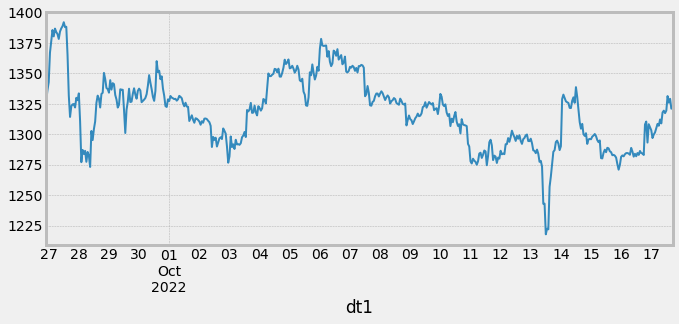

In [3]:
# get the data
url = 'https://cexa.oceanprotocol.io/ohlc?exchange=binance&pair=ETH/USDT&period=1h'
df = pd.read_json(url)
df.columns = ['dt1','open','high','low','close','volume']
# convert to UTC+0
a = [dt.fromtimestamp(x/1000) - relativedelta(hours=6) for x in df.dt1]
df['dt1'] = a
df.to_csv('data/ETH_USDT_free.csv', index = False)
df.set_index('dt1', inplace = True)

print(df.shape)
display(df[-3:])

_ = df['close'].plot(figsize = (10,4))

### Functions

In [62]:
# evaluation metrics
def ts_metrics(y_true, y_pred):
    return {
        'mae': metrics.mean_absolute_error(y_true, y_pred),
        'mse': metrics.mean_squared_error(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / y_true)),
        'smape': np.mean(np.abs( 2*(y_true - y_pred) / (y_true+np.abs(y_pred)))),
        'nmse':  np.sum((y_true - y_pred)**2) / np.sum((y_true)**2),
    }

# prophet model
from prophet import Prophet
def get_prophet(x,xv):
    # 1) prepare dataframe
    x = x.reset_index()
    x.columns = ['ds','y']

    # 2) build model
    m = Prophet(weekly_seasonality=True, daily_seasonality=True)
    m.fit(x)

    # # 3) predict
    t1 = 50
    df1 = m.make_future_dataframe(periods=t1, freq='h')
    df_out = m.predict(df1).set_index('ds')['yhat'][xv.index]

    return df_out

# exponential smoothing model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
def get_exponential(x,xv):
    # 1) build model
    model = ExponentialSmoothing(x, trend="add", seasonal="add", seasonal_periods=24*7, 
                                 use_boxcox=True, damped = False, initialization_method = 'estimated')
    fit1 = model.fit()
    
    # 2) predict
    t1 = 50
    pred1 = fit1.forecast(x.shape[0] + t1)
    pred1.index = list(x.index) + list(pd.date_range(x.index[-1], periods = t1+1, freq = 'h'))[1:]
    
    return pred1[xv.index]

### Models training

In [ ]:
day = 16       # this is the validation day (16 October)
hours_skip = 0 # all data before {day} - {hours_skip} will be used for training

# 1) generate dataset
x  = df.close[:f'2022-10-{day}'][:-hours_skip] if hours_skip > 0 else df.close[:f'2022-10-{day}']
xv = df.close[f'2022-10-{day}':f'2022-10-{day}']

# 2) models testing
out1 = list()
out2 = list()
# last value
x_pred = [x[-1]]*24
out1.append(ts_metrics(xv,x_pred))
out2.append('last')

# prophet model
x_pred = get_prophet(x,xv)
out1.append(ts_metrics(xv,x_pred))
out2.append('prophet')

# exponential smoothing model
x_pred = get_exponential(x,xv)
out1.append(ts_metrics(xv,x_pred))
out2.append('exponential')


In [84]:
# results
df_out = pd.DataFrame(out1)
df_out = -df_out
df_out['method'] = out2
df_out.style.background_gradient(cmap='RdYlGn')

,mae,mse,mape,smape,nmse,method
0,-18.322083,-393.544979,-0.014263,-0.014145,-0.000237,last
1,-5.647382,-77.421920,-0.004349,-0.004368,-0.000047,prophet
2,-16.554931,-306.320119,-0.012843,-0.012798,-0.000185,exponential


### Loop by parameters day and hours_skip

In [ ]:
out_day  = list()
out_skip = list()
out1 = list()
out2 = list()

for day in [14,15,16]:
    for hours_skip in range(13):
        # 1) generate dataset
        x  = df.close[:f'2022-10-{day}'][:-hours_skip] if hours_skip > 0 else df.close[:f'2022-10-{day}']
        xv = df.close[f'2022-10-{day}':f'2022-10-{day}']

        # 2) models testing
        # last value
        x_pred = [x[-1]]*24
        out1.append(ts_metrics(xv,x_pred))
        out2.append('last')
        out_day.append(day)
        out_skip.append(hours_skip)

        # prophet model
        x_pred = get_prophet(x,xv)
        out1.append(ts_metrics(xv,x_pred))
        out2.append('prophet')
        out_day.append(day)
        out_skip.append(hours_skip)

        # exponential smoothing model
        x_pred = get_exponential(x,xv)
        out1.append(ts_metrics(xv,x_pred))
        out2.append('exponential')
        out_day.append(day)
        out_skip.append(hours_skip)

In [86]:
# results
df_out = pd.DataFrame(out1)
df_out['method'] = out2
df_out['day'] = out_day
df_out['hours_skip'] = out_skip

In [109]:
# the best metrics for the methods
pd.options.display.float_format = '{:,.6f}'.format
df_out.groupby(['method','day'])['nmse','mse','mae','mape'].min().unstack()

nmse                             mse                          \
day               14       15       16            14           15         16   
method                                                                         
exponential 0.007419 0.004421 0.000128 12,851.449538 7,326.537462 212.199923   
last        0.000136 0.000039 0.000054    236.441487    65.011750  89.075313   
prophet     0.000163 0.000009 0.000047    282.473698    14.992973  77.421920   

                   mae                        mape                    
day                 14        15       16       14       15       16  
method                                                                
exponential 109.578713 85.345469 9.183035 0.083042 0.066305 0.007068  
last         12.863750  6.647500 5.422917 0.009830 0.005156 0.004164  
prophet      15.036990  2.346065 5.122902 0.011374 0.001828 0.003936

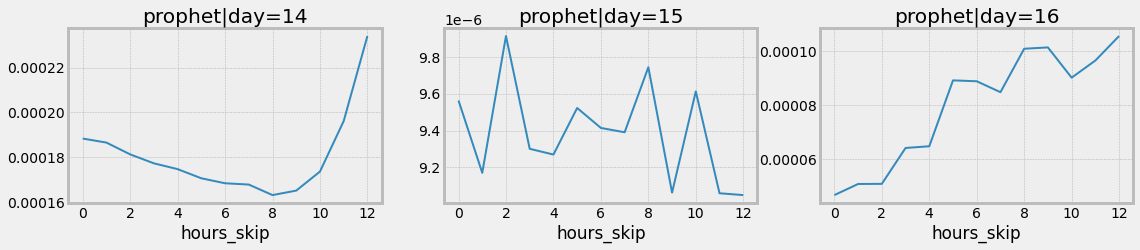

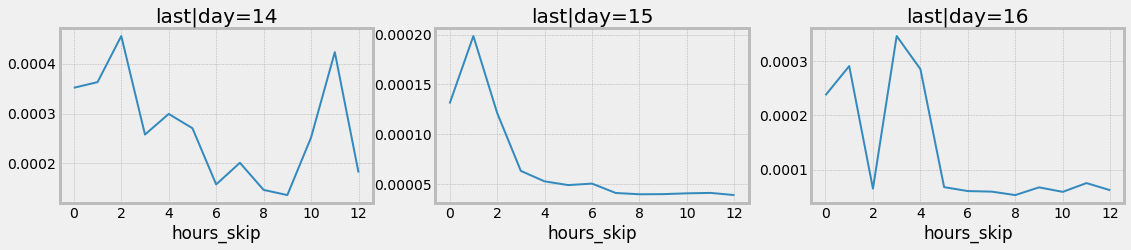

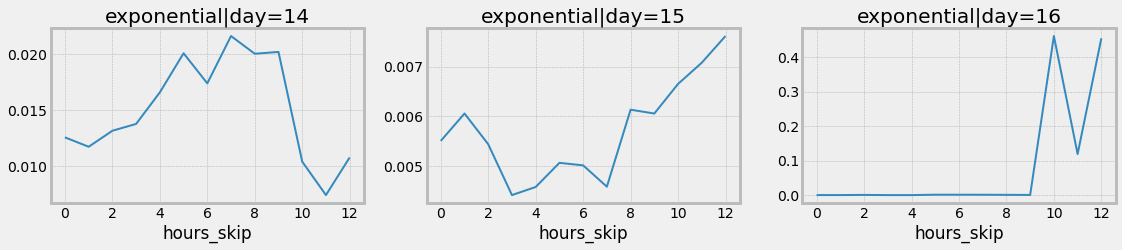

In [103]:
for m in ['prophet','last','exponential']:
    _, ax = plt.subplots(1,3, figsize = (17,3))
    for i,d in enumerate([14,15,16]):
        f1 = df_out.method == m
        f2 = df_out.day == d
        df_out[f1&f2].set_index('hours_skip').nmse.plot(ax = ax[i], title = f'{m}|day={d}')

In [102]:
# df_out1 = pd.pivot_table(df_out[df_out.day == 16], index = 'hours_skip', columns = 'method', values = 'nmse')
# # df_out1 = df_out1.clip(0,0.0001)
# df_out1[:5].plot(figsize = (15,7))